# Food Sales Prediction
- Zach Hanson
- Last updated 12/22/2022
 

## Project Description

### Task

- To create different models to help the retailer understand the properties of products and outlets that play a role in predicting sales.

### Data Dictionary

**Variable Name** | **Description**
--- | ---
Item_Identifier | Unique product ID
Item_Weight | Weight of product
Item_Fat_Content | Whether the product is low fat or regular
Item_Visibility | The percentage of total display area of all products in a store allocated to the particular product
Item_Type | The category to which the product belongs
Item_MRP | Maximum Retail Price (list price) of the product
Outlet_Identifier | Unique store ID
Outlet_Establishment_Year | The year in which store was established
Outlet_Size | The size of the store in terms of ground area covered
Outlet_Location_Type | The type of area in which the store is located
Outlet_Type | Whether the outlet is a grocery store or some sort of supermarket
Item_Outlet_Sales | Sales of the product in the particular store

### Import Libraries

In [1]:
#Pandas
import pandas as pd

#NumPy
import numpy as np

#Matplotlib
import matplotlib.pyplot as plt

#Seaborn
import seaborn as sns

#Imputers
from sklearn.impute import SimpleImputer

#Transformers
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

#Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

#Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

#Regression Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Setting global SciKit-Learn configuration
from sklearn import set_config
set_config(display='diagram')

### Functions

In [2]:
#Function to take the true and predicted values 
#and print MAE, MSE, RMSE, and R2 metrics
def evaluation_model(pipe,
                     model_name = '',
                     x_train = 'X_train', 
                     x_test ='X_test'):
    
    #Train
    mae = round(mean_absolute_error(y_train, pipe.predict(x_train)),4)
    mse = round(mean_squared_error(y_train, pipe.predict(x_train)),4)
    rmse = round(np.sqrt(mean_squared_error(y_train, pipe.predict(x_train))),4)
    r2 = round(r2_score(y_train, pipe.predict(x_train)),7)
    print(f'{model_name} Train Scores')
    print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2:{r2:.4f}\n')
    
    #Test
    mae = round(mean_absolute_error(y_test, pipe.predict(x_test)),4)
    mse = round(mean_squared_error(y_test, pipe.predict(x_test)),4)
    rmse = round(np.sqrt(mean_squared_error(y_test, pipe.predict(x_test))),4)
    r2 = round(r2_score(y_test, pipe.predict(x_test)),7)

    # Display the metrics for the model
    print(f'{model_name} Test Scores')
    print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

## Loading and Inspecting Data

### Loading Data

In [3]:
#Import data
df_original = pd.read_csv('sales_predictions.csv')

### Inspect Data

In [4]:
df_original.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


- Data seems to be loaded properly

In [5]:
#Showing shape of data frame
df_original.shape

(8523, 12)

- There are 8,523 data entries
- There are 12 columns
 - 11 features and 1 target

In [6]:
#Viewing column names, data types, and count of non-null values
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [7]:
#Showing descriptive statistics for numerical data
df_original.describe(include='number')

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [8]:
#Showing descriptive statistics for categorical data
df_original.describe(include='object')

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,8523,6113,8523,8523
unique,1559,5,16,10,3,3,4
top,FDW13,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,10,5089,1232,935,2793,3350,5577


## Cleaning Data

### Remove Unnecessary Columns


In [9]:
df_original['Item_Identifier'].value_counts()

FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64

In [10]:
#Dropping Item Identifier column
df_original = df_original.drop(columns='Item_Identifier')

- Chose to remove this column because almost 20% of the data has a different value
- Most likely not crucial in predicting an items outlet sales, as we would be using these models to predict new items

In [11]:
#Dropping Item Weight column
df_original = df_original.drop(columns='Item_Weight')

- Chose to remove this column because an items weight likely has extremely little to no influence on its sales.

In [12]:
#Dropping Outlet Identifier columnd
df_original = df_original.drop(columns='Outlet_Identifier')

- Similar to the Item identifier, the unique store is likely not crucial in predicting an items outlet sales

In [13]:
#Dropping Outlet Establishment Year
df_original = df_original.drop(columns='Outlet_Establishment_Year')

- Year an outlet was established likely has little to no influence on its outlet sales

### Remove Unnecessary Rows

#### Duplicates

In [14]:
#Checking for duplicate rows
dup = df_original.duplicated().sum()

print(f'There are {dup} duplicated rows.')

There are 0 duplicated rows.


- No duplicated rows

### Inspect Column Data-types for Errors

In [15]:
#Display column names and datatypes
df_original.dtypes

Item_Fat_Content         object
Item_Visibility         float64
Item_Type                object
Item_MRP                float64
Outlet_Size              object
Outlet_Location_Type     object
Outlet_Type              object
Item_Outlet_Sales       float64
dtype: object

- All columns appear to have the correct data types

### Inspect Column Names for Errors

In [16]:
#Display column names
df_original.columns

Index(['Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type',
       'Item_Outlet_Sales'],
      dtype='object')

- No errors in column names noticeable

### Inspect Values for Errors

#### Numeric Columns

In [17]:
#Display summary statistics for numeric columns
df_original.describe(include='number')

,Item_Visibility,Item_MRP,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000
mean,0.066132,140.992782,2181.288914
std,0.051598,62.275067,1706.499616
min,0.000000,31.290000,33.290000
25%,0.026989,93.826500,834.247400
50%,0.053931,143.012800,1794.331000
75%,0.094585,185.643700,3101.296400
max,0.328391,266.888400,13086.964800


- No unusual values noted

#### Categorical Columns

In [18]:
#Checking Item_Fat_Content for inconsistencies
df_original['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

- We can see we have 'LF', 'reg', and 'low fat'

In [19]:
#Updating so everything is consistent
df_original = df_original.replace(['LF', 'low fat', 'reg'],
                                  ['Low Fat', 'Low Fat', 'Regular'])

In [20]:
#Checking to make sure everything got replaced
df_original['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

- Updated correctly

### Missing Values

In [21]:
#Display count of missing values by column
print(df_original.isna().sum())

Item_Fat_Content           0
Item_Visibility            0
Item_Type                  0
Item_MRP                   0
Outlet_Size             2410
Outlet_Location_Type       0
Outlet_Type                0
Item_Outlet_Sales          0
dtype: int64


- We can see there is 1,463 values missing in 'Item_Weight' column, and 2,410 values missing in 'Outlet_Size' column

In [22]:
#Showing percentage of missing values by column
print(df_original.isna().sum()/len(df_original)*100)

Item_Fat_Content         0.000000
Item_Visibility          0.000000
Item_Type                0.000000
Item_MRP                 0.000000
Outlet_Size             28.276428
Outlet_Location_Type     0.000000
Outlet_Type              0.000000
Item_Outlet_Sales        0.000000
dtype: float64


In [23]:
#Showing total number of missing values
print(f'There are {df_original.isna().sum().sum()} total missing values.')

There are 2410 total missing values.


- We will need to impute both the Item_Weight column and Outlet_Size column
- Item_Weight we can impute with the mean of the other values recorded
- Outlet_Size we can impute with "Missing", since we would be adding a lot of bias with the large amount of missing data in this column

## Visualization Models

### Copying Data

In [24]:
#Copying original data frame to prevent data leakage
vis_df = df_original.copy()

In [25]:
#Checking to see if it got copied
vis_df.head()

,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,Low Fat,0.016047,Dairy,249.8092,Medium,Tier 1,Supermarket Type1,3735.1380
1,Regular,0.019278,Soft Drinks,48.2692,Medium,Tier 3,Supermarket Type2,443.4228
2,Low Fat,0.016760,Meat,141.6180,Medium,Tier 1,Supermarket Type1,2097.2700
3,Regular,0.000000,Fruits and Vegetables,182.0950,NaN,Tier 3,Grocery Store,732.3800
4,Low Fat,0.000000,Household,53.8614,High,Tier 3,Supermarket Type1,994.7052


- Appears to have copied correctly

### Data Cleaning for Visualization


In [26]:
#Checking to see if there is any missing values
vis_df.isna().sum()

Item_Fat_Content           0
Item_Visibility            0
Item_Type                  0
Item_MRP                   0
Outlet_Size             2410
Outlet_Location_Type       0
Outlet_Type                0
Item_Outlet_Sales          0
dtype: int64

In [27]:
#Replacing all the missing 'Outlet_Size' values with "Unknown"
vis_df = vis_df.fillna("Unknown")

In this case I chose to keep the "Outlet_Size" column because I do believe it might be valuable in determining the sales of an item. I replaced all the missing values with "Unknown".

In [28]:
#Double checking to make sure we removed all missing values
vis_df.isna().sum()

Item_Fat_Content        0
Item_Visibility         0
Item_Type               0
Item_MRP                0
Outlet_Size             0
Outlet_Location_Type    0
Outlet_Type             0
Item_Outlet_Sales       0
dtype: int64

All the missing data has been removed

In [29]:
#Checking inconsistent data in Item_Fat_Content category
vis_df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

We can see there is also values for "LF", "reg", and "low fat"

In [30]:
#Updating this inconsistent data so everything is the same
vis_df = vis_df.replace(['LF', 'low fat', 'reg'], ['Low Fat', 'Low Fat', 'Regular'])

#Checking to make sure everything got replaced
vis_df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

- Updated 'LF' and 'low fat' to 'Low Fat'
- Updated 'reg' to 'Regular'

### Exploratory Visuals

#### Histograms

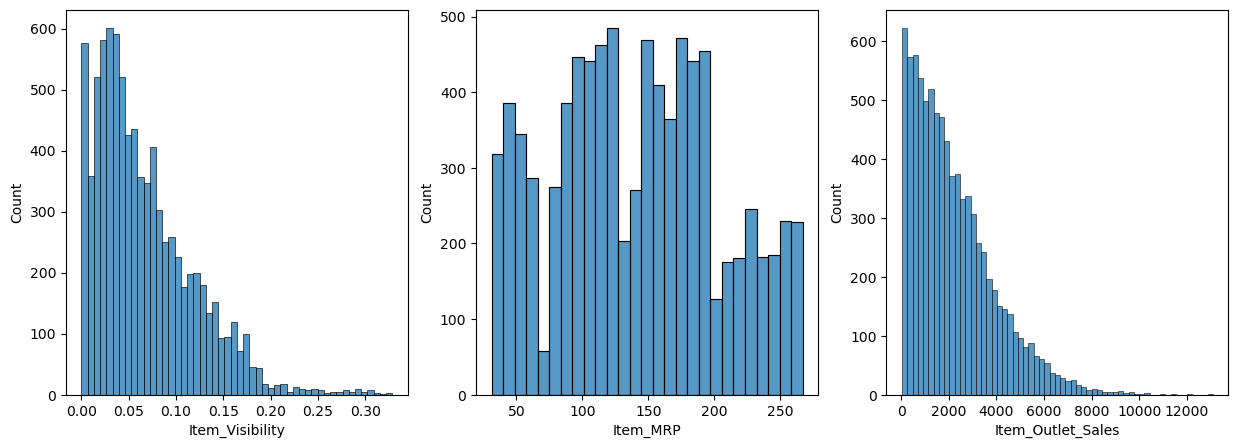

In [31]:
#Creating subplot to contain all our histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#Adding 'Item_Visibility' to subplots
sns.histplot(ax=axes[0], data=vis_df, x='Item_Visibility');

#Adding 'Item_MRP' to subplots
sns.histplot(ax=axes[1], data=vis_df, x='Item_MRP');

#Adding 'Item_Outlet_Sales' to subplots
sns.histplot(ax=axes[2], data=vis_df, x='Item_Outlet_Sales');

- Item_Visibility
 - This histogram is right skewed
 - Mean may be inaccurate due to large amount of '0' entries for this category
- Item_MRP
 - Fairly evenly spread for all the values
 - The unit price for each item is pretty evenly spread
- Item_Outlet_Sales
 - This histogram is right skewed
 - Many items have low amounts of sales at certain stores
 - Few items with large amounts of sales

#### Boxplots

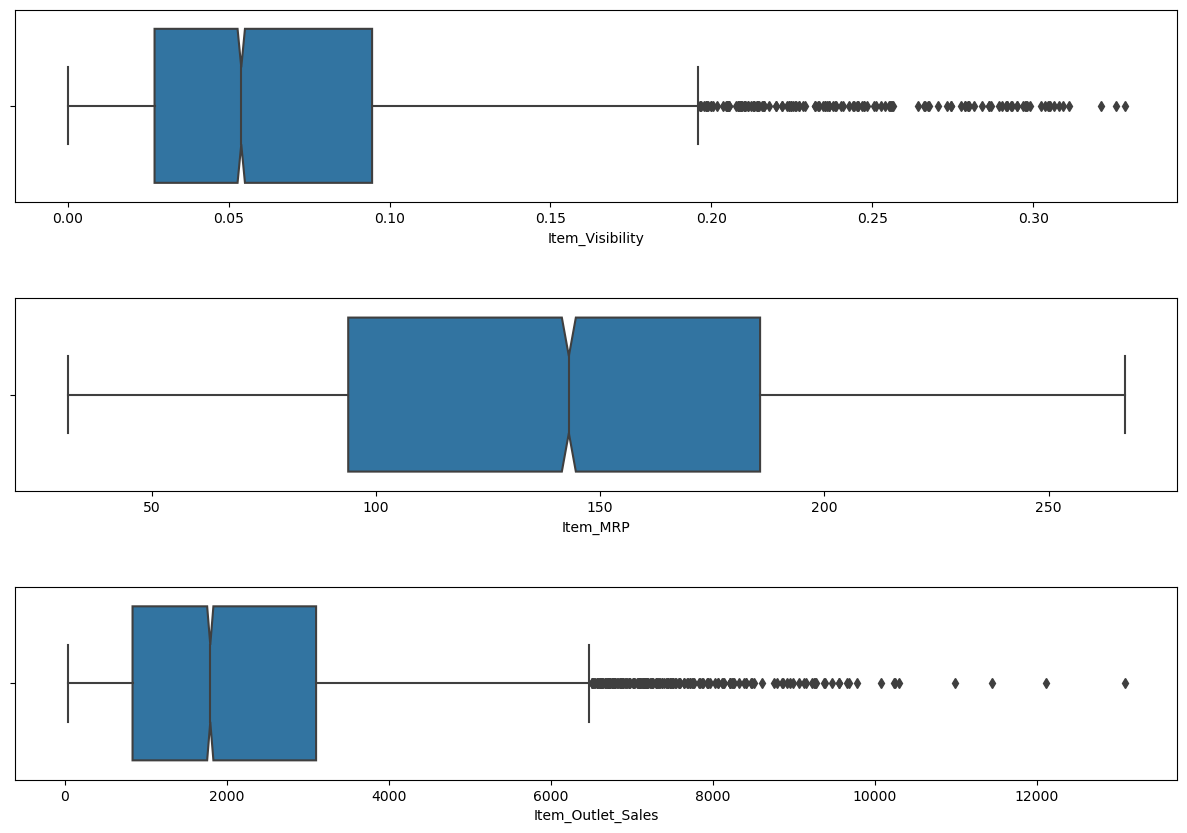

In [32]:
#Creating subplot to contain all our boxplots
fig, axes = plt.subplots(3, 1, figsize=(15,10))

#Adjusting padding between the 3 subplots for readability
fig.subplots_adjust(hspace=0.5)

#Adding 'Item_Visibility' to subplots
sns.boxplot(ax=axes[0], data=vis_df, x='Item_Visibility', notch=True);

#Adding 'Item_MRP' to subplots
sns.boxplot(ax=axes[1], data=vis_df, x='Item_MRP', notch=True);

#Adding 'Item_Outlet_Sales' to subplots
sns.boxplot(ax=axes[2], data=vis_df, x='Item_Outlet_Sales', notch=True);

- Item Visibility
 - Very low average item visibility
 - Top 25% of data has a fairly large range of values, anywhere from 0.09 to 0.19
 - Bottom 50% of data is bunched below 0.06, may be skewed because of large amount of values at 0
- Item MRP
 - Very even spread of values
 - Top 25% of data has a slightly larger range of values compared to the bottom 25%
- Item Outlet Sales
 - Similar to item visibility, the average is fairly low compared to the upper range of values
 - Top 25% also has large range of values compared to bottom 50% of data
 - Few very large outliers in this data set, over 6 times the mean in two cases

#### Heatmap

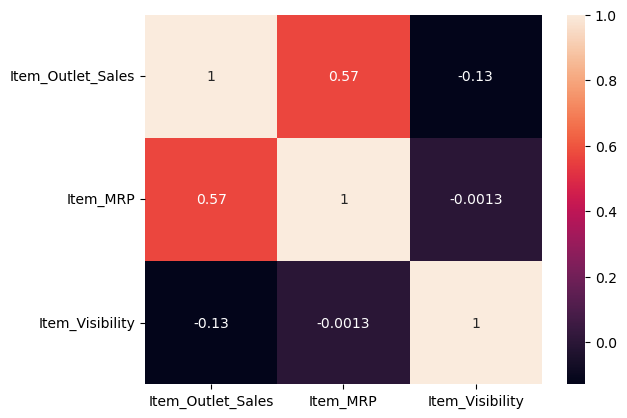

In [33]:
#Heat map of item outlet sales, item mrp and item visibilty

#Calculate correlations in numerical values for Total outlet sales, the item MRP, and the item visibility
vis_corr = vis_df[['Item_Outlet_Sales','Item_MRP','Item_Visibility']].corr()

#Create a heat map of the correlations
sns.heatmap(vis_corr,               #Input data 
            annot = True);       #Show correlation values on the heatmap

#Rotating the y labels 90 degrees for readability
plt.yticks(rotation = 0);

- There is a moderately strong positive correlation between 'Item MRP' and 'Item Outlet Sales'
- All other correlations are negligible 

### Explanatory Visuals

#### MRP and Total Sales sorted by Store Size

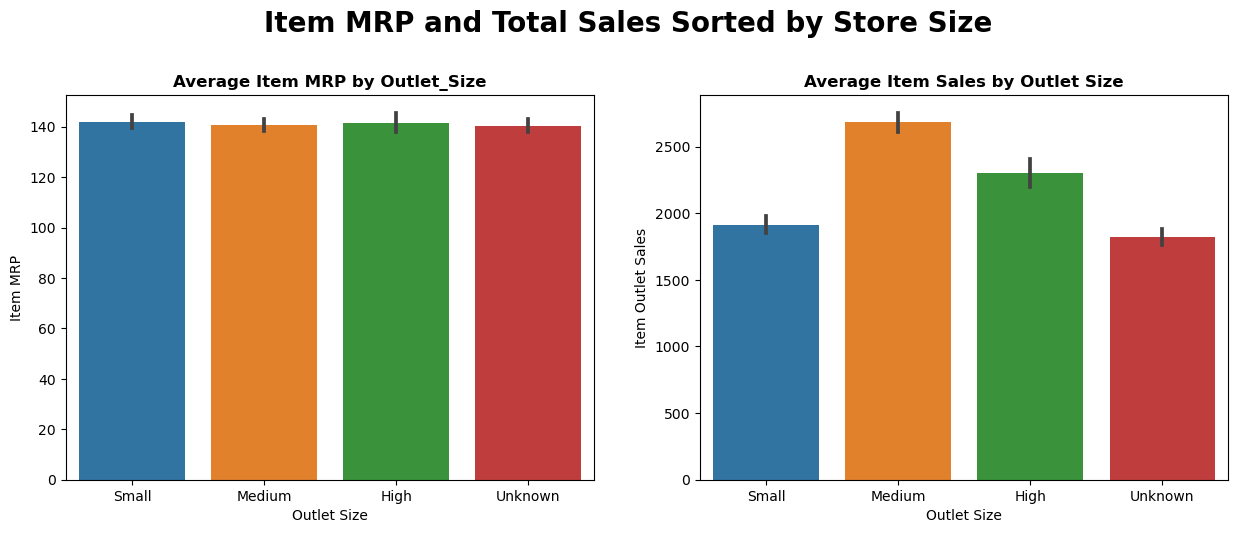

In [34]:
#Creating Subplot for both our bar charts
fig, axes = plt.subplots(ncols = 2, figsize=(15, 5))

#Creating bar chart with item MRP
sns.barplot(data = vis_df,                                  #Choosing which data to use
            x = 'Outlet_Size',                                #What goes on x axis
            y= 'Item_MRP',                                    #What goes on y axis
            ax = axes[0],                                     #Which subplot this barplot goes to
            order = ['Small', 'Medium', 'High', 'Unknown']    #Order of x axis
            );

#Creating bar chart with total sales
sns.barplot(data = vis_df,
            x = 'Outlet_Size',
            y= 'Item_Outlet_Sales',
            ax = axes[1],
            order = ['Small', 'Medium', 'High', 'Unknown']
            );

#Adding Titles to subplots
axes[0].set_title('Average Item MRP by Outlet_Size',
                  fontsize = 12,                #Fontsize 12
                  fontweight = 'bold');         #Bolding font
axes[1].set_title('Average Item Sales by Outlet Size',
                  fontsize = 12,
                  fontweight = 'bold');
#Adding title to overall data
fig.suptitle('Item MRP and Total Sales Sorted by Store Size',
             fontsize = 20,
             fontweight = 'bold',
             y = 1.05);                         #Location on y-axis of subplots for title

#Removing '_' from axis labels to make it look better
axes[0].set(xlabel='Outlet Size', ylabel='Item MRP');
axes[1].set(xlabel='Outlet Size', ylabel='Item Outlet Sales');

Interpretation
- Outlet Size has little to no impact on an items MRP
- Outlet Size may have a small impact on total item sales, but hard to determine with large amount of missing data in this category

#### MRP and Total Sales sorted by Store Location

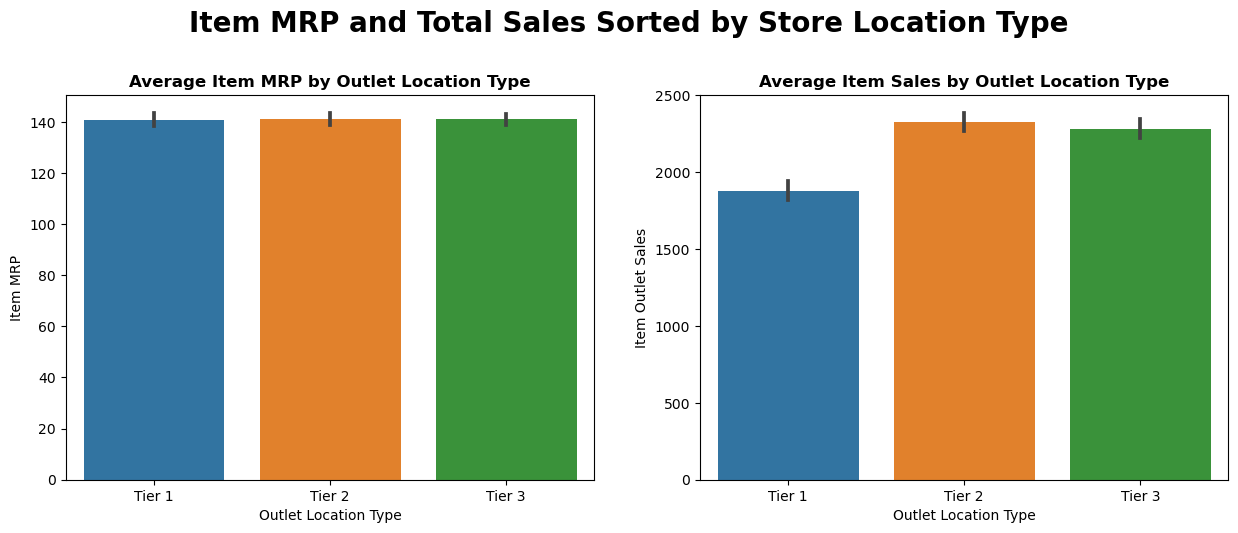

In [35]:
#Creating Subplot for both our bar charts
fig, axes = plt.subplots(ncols = 2, figsize=(15, 5))

#Creating bar chart with item MRP
sns.barplot(data = vis_df,
            x = 'Outlet_Location_Type',
            y= 'Item_MRP',
            ax = axes[0],
            order = ['Tier 1', 'Tier 2', 'Tier 3']
            );

#Creating bar chart with total sales
sns.barplot(data = vis_df,
            x = 'Outlet_Location_Type',
            y= 'Item_Outlet_Sales',
            ax = axes[1],
            order = ['Tier 1', 'Tier 2', 'Tier 3']
            );

#Adding Titles to subplots
axes[0].set_title('Average Item MRP by Outlet Location Type',
                  fontsize = 12,
                  fontweight = 'bold');
axes[1].set_title('Average Item Sales by Outlet Location Type',
                  fontsize = 12,
                  fontweight = 'bold');
#Adding title to overall data
fig.suptitle('Item MRP and Total Sales Sorted by Store Location Type', fontsize = 20, fontweight = 'bold', y = 1.05);

#Removing '_' from axis labels to make it look better
axes[0].set(xlabel='Outlet Location Type', ylabel='Item MRP');
axes[1].set(xlabel='Outlet Location Type', ylabel='Item Outlet Sales');

Interpretation
- Outlet location type has little to no impact on an item's MRP
- Outlet location type of Tier 2 and Tier 3 have, on average, higher total item sales compared to Tier 1 location type

#### MRP and Total Sales sorted by Store Type

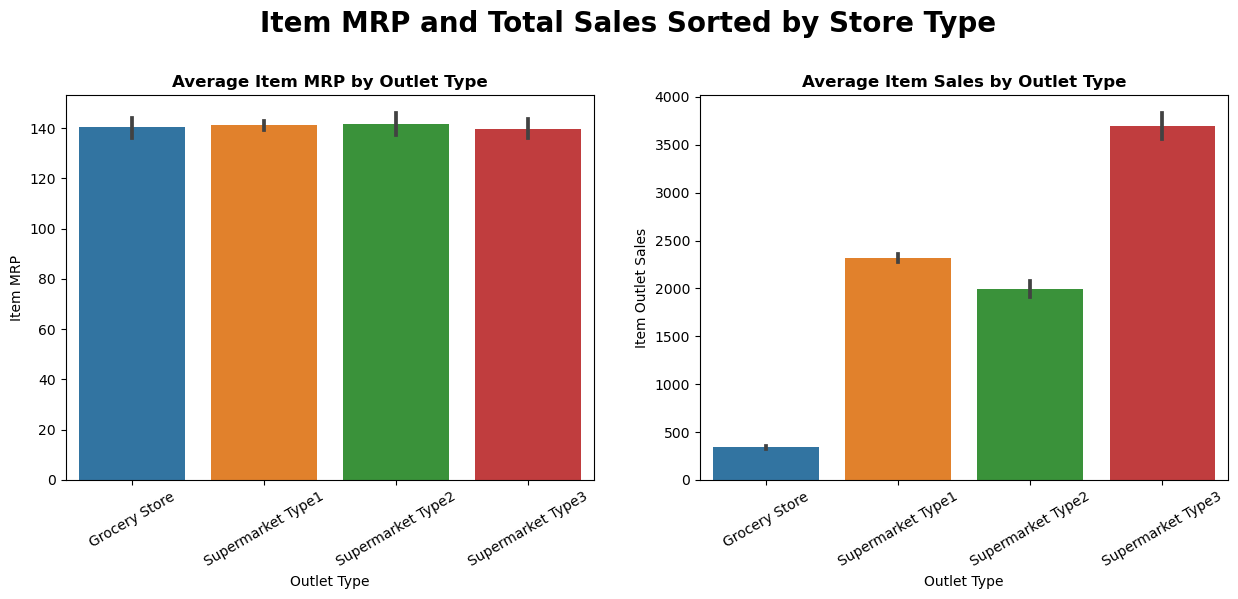

In [36]:
#Creating Subplot for both our bar charts
fig, axes = plt.subplots(ncols = 2, figsize=(15, 5))

#Creating bar chart with item MRP
p1 = sns.barplot(data = vis_df,
            x = 'Outlet_Type',
            y= 'Item_MRP',
            ax = axes[0],
            order = ['Grocery Store', 'Supermarket Type1', 'Supermarket Type2', 'Supermarket Type3']
            );
#Rotating x axis labels for readability
p1.set_xticklabels(p1.get_xticklabels(), rotation=30);

#Creating bar chart with total sales
p2 = sns.barplot(data = vis_df,
            x = 'Outlet_Type',
            y= 'Item_Outlet_Sales',
            ax = axes[1],
            order = ['Grocery Store', 'Supermarket Type1', 'Supermarket Type2', 'Supermarket Type3']
            );
#Rotating x axis labels for readability
p2.set_xticklabels(p2.get_xticklabels(), rotation=30);

#Adding Titles to subplots
axes[0].set_title('Average Item MRP by Outlet Type',
                  fontsize = 12,
                  fontweight = 'bold');
axes[1].set_title('Average Item Sales by Outlet Type',
                  fontsize = 12,
                  fontweight = 'bold');
#Adding title to overall data
fig.suptitle('Item MRP and Total Sales Sorted by Store Type', fontsize = 20, fontweight = 'bold', y = 1.05);

#Removing '_' from axis labels to make it look better
axes[0].set(xlabel='Outlet Type', ylabel='Item MRP');
axes[1].set(xlabel='Outlet Type', ylabel='Item Outlet Sales');

Interpretation
- Outlet type has little to no impact on an item's MRP
- Outlet type has a large impact on an items total sales
 - Supermarket Type 3 has just under 50% more sales than Supermarket Type 1 and 2
 - Supermarket Type 3 has just over 3000 more sales on average than Grocery Store 
 - Supermarket Type 1 and 2 have close to the same total sales, with Type 1 having around 300 more than Type 2
 - Supermarket Type 1 and 2 have between 1500 and 2000 more total sales than Grocery Store

#### Overall Interpretation

If looking for the highest amount of total sales, based on the data we have the ideal outlet would be a medium size, Supermarket Type 3, located in a Tier 2 or Tier 3 location. It should be noted that the size and location have a significantly smaller impact on an items sales compared to the type of outlet, and the store size has a slightly larger impact than location. 

## Splitting Data

### Copying Data

In [37]:
#Copying original data frame to prevent data leakage
reg_df = df_original.copy()

In [38]:
#Checking to see if it got copied
reg_df.head()

,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,Low Fat,0.016047,Dairy,249.8092,Medium,Tier 1,Supermarket Type1,3735.1380
1,Regular,0.019278,Soft Drinks,48.2692,Medium,Tier 3,Supermarket Type2,443.4228
2,Low Fat,0.016760,Meat,141.6180,Medium,Tier 1,Supermarket Type1,2097.2700
3,Regular,0.000000,Fruits and Vegetables,182.0950,NaN,Tier 3,Grocery Store,732.3800
4,Low Fat,0.000000,Household,53.8614,High,Tier 3,Supermarket Type1,994.7052


- Appears to have copied correctly

### Splitting Data

In [39]:
#Define features (X) and target (y)
target = 'Item_Outlet_Sales'
y = reg_df[target].copy()
X = reg_df.drop(columns = [target]).copy()

In [40]:
#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
#Random state 42 for consistency

## Preparing Data

### Column Selectors

In [41]:
#Numerical column selector
num_selector = make_column_selector(dtype_include='number')

#Categorical column selector
cat_selector = make_column_selector(dtype_include='object')

### Imputers

In [42]:
#Mean imputer for numerical data
mean_imputer = SimpleImputer(strategy='mean')

In [43]:
#Categorical imputer to fill missing nominal data with 'Missing'
missing_imputer = SimpleImputer(strategy='constant',   #Replace all missing values with same thing
                                fill_value='Missing')  #Replace all missing values with "Missing"

### Transformers

In [44]:
#Instantiate scaler and one hot encoder
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

### Imputer Pipeline

#### Numerical Pipeline

In [45]:
num_pipeline = make_pipeline(mean_imputer, scaler)
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

#### Categorical Pipeline

In [46]:
cat_pipeline = make_pipeline(missing_imputer, ohe)
#cat_pipeline = make_pipeline(ohe)

cat_pipeline

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='Missing', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

### Tuples

In [47]:
#Numerical Tuple
num_tuple = (num_pipeline, num_selector)

#Categorical Tuple
cat_tuple = (cat_pipeline, cat_selector)

### Column Transformer

In [48]:
preprocessor = make_column_transformer(num_tuple,
                                       cat_tuple,
                                       remainder='drop')
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001FAAF0DF3D0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001FAAF0DF6A0>)])

## Regression Metrics

### Linear Regression

In [49]:
#Creating instance of model
lin_reg = LinearRegression()

In [50]:
#Create a model pipeline
lin_reg_pipeline = make_pipeline(preprocessor, lin_reg)

In [51]:
#Fit the model to training data
lin_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FAAF0DF3D0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FAAF0DF6A0>)])),
                ('linearregression', LinearRegression())])

In [52]:
#Running regression metrics on this model
evaluation_model(pipe = lin_reg_pipeline,
                 model_name = 'Linear Regression Model',
                 x_train = X_train,
                 x_test = X_test)

Linear Regression Model Train Scores
MAE: 847.0918 
MSE: 1,298,710.6116 
RMSE: 1,139.6099 
R2:0.5612

Linear Regression Model Test Scores
MAE: 805.4938 
MSE: 1,197,068.1397 
RMSE: 1,094.1061 
R2: 0.5661



- The R^2 value for this model is 0.5671 on our testing set.
- This model can use all the features to account for about 57% of the variance in the target value
- This model can predict the target value with about 1,100 sales error

### Regression Tree Model

In [53]:
#Generating Forest
rf = RandomForestRegressor(random_state=42)
#random state 42 for consistency

In [54]:
#Creating random forest pipeline
rf_pipe = make_pipeline(preprocessor, rf)

In [55]:
#Fitting to training data
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FAAF0DF3D0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FAAF0DF6A0>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [56]:
#Finding max depth if we let this model have unlimited max_depth
est_depths = [estimator.get_depth() for estimator in rf.estimators_]
max(est_depths)

42

- If we let this model have an unlimited max_depth, the highest it will go is 42

In [57]:
#Finding best depth for this model 
depths = range(1, 42) #Max range found from above line

#Making new data frame to save information
scores = pd.DataFrame(index=depths, columns=['Test Score'])

for depth in depths:    
    model = RandomForestRegressor(max_depth=depth, random_state=42)
    model_pipe = make_pipeline(preprocessor, model)
    model_pipe.fit(X_train, y_train)
    
    scores.loc[depth, 'Train Score'] = model_pipe.score(X_train, y_train)
    scores.loc[depth, 'Test Score'] = model_pipe.score(X_test, y_test)


In [58]:
#Sorting scores to see which depth gives us best R^2 value
sorted_scores = scores.sort_values(by='Test Score',
                                   ascending=False)
sorted_scores.head()

,Test Score,Train Score
5,0.602681,0.610508
6,0.600831,0.623726
7,0.59684,0.641781
4,0.596629,0.595918
8,0.595032,0.664095


- Depth of 5 yields the highest R^2 value for our testing set

In [59]:
#Finding best n_estimators using our best depth
n_est = [50, 100, 150, 200, 250, 300]
scores2 = pd.DataFrame(index=n_est, columns=['Test Score', 'Train Score'])

for n in n_est:
    model = RandomForestRegressor(max_depth=5, n_estimators=n, random_state=42)
    model_pipe = make_pipeline(preprocessor, model)
    model_pipe.fit(X_train, y_train)
    
    scores2.loc[n, 'Train Score'] = model_pipe.score(X_train, y_train)
    scores2.loc[n, 'Test Score'] = model_pipe.score(X_test, y_test)

In [60]:
#Sorting scores to see which n_estimator gives us best R^2 value
sorted_scores2 = scores2.sort_values(by='Test Score',
                                     ascending=False)
sorted_scores2.head()

,Test Score,Train Score
300,0.603036,0.610421
150,0.603016,0.61033
250,0.602996,0.610448
200,0.602929,0.610351
100,0.602681,0.610508


- n_estimator of 300 yields the highest R^2 value for our testing set

In [61]:
#Generating optimal random forest
rf_opt = RandomForestRegressor(max_depth=5,
                               n_estimators=300,
                               random_state=42)

In [62]:
#Creating pipeline
rf_opt_pipe = make_pipeline(preprocessor, rf_opt)

In [63]:
rf_opt_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FAAF0DF3D0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FAAF0DF6A0>)])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=5, n_estimators=300,
                                       random_state=42))])

In [64]:
#Running regression metrics on this model
evaluation_model(pipe = rf_opt_pipe,
                 model_name = 'Optimal Random Forest Model',
                 x_train = X_train,
                 x_test = X_test)

Optimal Random Forest Model Train Scores
MAE: 755.4340 
MSE: 1,152,942.3320 
RMSE: 1,073.7515 
R2:0.6104

Optimal Random Forest Model Test Scores
MAE: 728.4820 
MSE: 1,095,215.7791 
RMSE: 1,046.5256 
R2: 0.6030



- The R^2 value for this model is 0.6030 on our testing set.
- This model can use all the features to account for about 60% of the variance in the target value
- This model can predict the target value with about 1,050 sales error

### Recommendation

- I would recommend using a random forest regression model to predict an items outlet sales. 
 - Features to use:
   - max_depth = 5
   - n_estimators = 300

- This model predicts the output with about 50 units less error
- This model can use the features to account for about 3% more variance than a standard linear regression model